## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

Загрузим все необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from numpy.linalg import inv
from sklearn.utils import shuffle
from IPython.display import display
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from pymystem3 import Mystem
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import seaborn as sns
import time

Загрузим массив данных и взглянем на информацию о нем.

In [2]:
df = pd.read_csv('/datasets/taxi.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


2 столбца и 26496 строк. Целевой признак - столбец num_orders. Признак - datetime. Посмотрим на массив.

In [3]:
df

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


Проверим есть ли пропуски.

In [4]:
df.isnull().sum()

datetime      0
num_orders    0
dtype: int64

Пропусков нет, проверим на дубликаты.

In [5]:
df.duplicated().sum()

0

Дубликатов нет. Начнем семплирование столбца datetime до часа для получения большего количества признаков для обучения. Сначала переведем тип данных datetime с object в datetime.

In [6]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null datetime64[ns]
num_orders    26496 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Установим datetime в качестве индекса.

In [7]:
df = df.set_index('datetime')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Теперь ресемпл.

In [8]:
df = df.resample('1H').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Подготовка завершена, переходим к анализу.

# 2. Анализ

Для начала построим график.

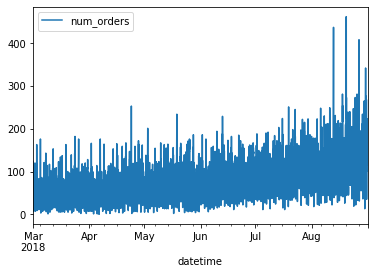

In [9]:
df.plot()

Не слишком информативно. Попробуем применить seasonal_decompose.

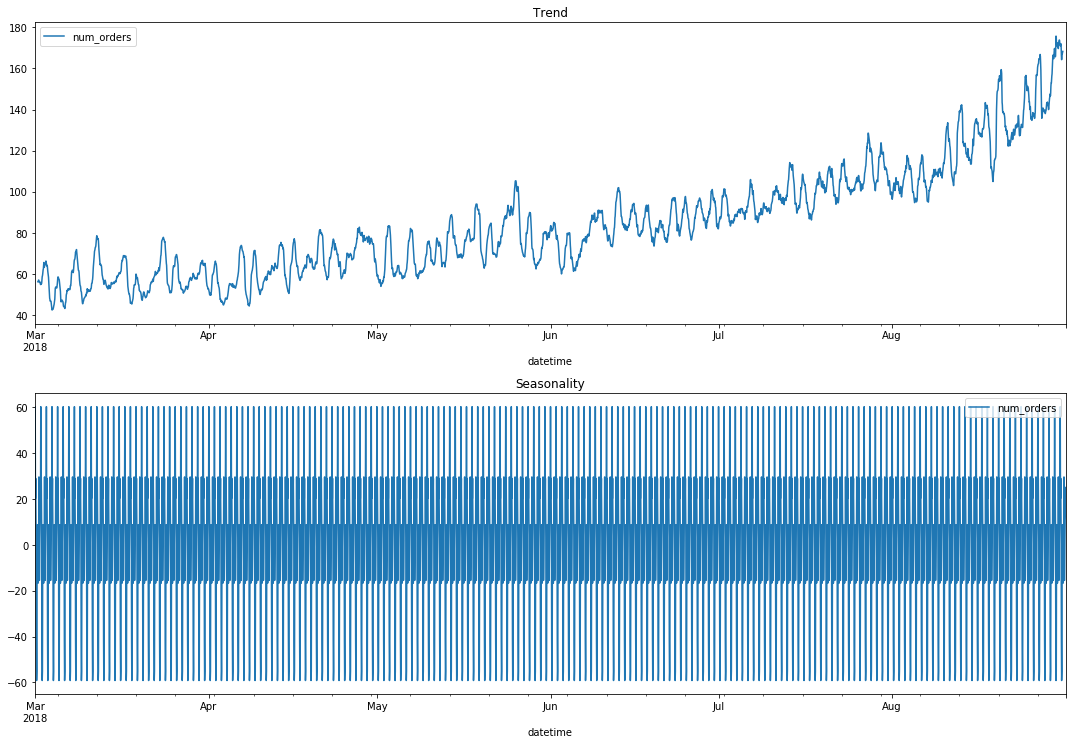

In [10]:
decomposed = seasonal_decompose(df) 
plt.figure(figsize=(15, 15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.tight_layout()

Добавим столбцы dayofweek и hour.

In [11]:
df['dayofweek'] = df.index.dayofweek
df['hour'] = df.index.hour
df

,num_orders,dayofweek,hour
datetime,,,
2018-03-01 00:00:00,124,3,0
2018-03-01 01:00:00,85,3,1
2018-03-01 02:00:00,71,3,2
2018-03-01 03:00:00,66,3,3
2018-03-01 04:00:00,43,3,4
...,...,...,...
2018-08-31 19:00:00,136,4,19
2018-08-31 20:00:00,154,4,20
2018-08-31 21:00:00,159,4,21


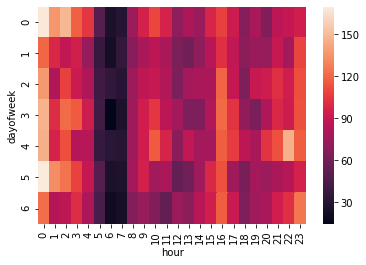

In [12]:
ride = df.pivot_table('num_orders', 'dayofweek', 'hour')
ax_1 = sns.heatmap(ride)

Сезонность не отследить, а количество заказов неуклонно растет от месяца к месяцу. На тепловой диаграмме отчетливо прослеживается только падение количества заказов в диапазоне от 5 до 7 утра и рост заказов на рубеже суток, около полуночи. Предположим, что ситуация отличается в будние и выходные дни. Поэтому возьмем два временных отрезка - будние дни (от 07:00 понедельника до 16:00 пятницы) и выходные дни (от 16:00 пятницы до 07:00 понедельника). 

Создадим два массива данных.

In [13]:
work = df.query('dayofweek == [1, 2, 3] or (dayofweek == 0 and hour > 7) or (dayofweek == 4 and hour < 16)')
work

,num_orders,dayofweek,hour
datetime,,,
2018-03-01 00:00:00,124,3,0
2018-03-01 01:00:00,85,3,1
2018-03-01 02:00:00,71,3,2
2018-03-01 03:00:00,66,3,3
2018-03-01 04:00:00,43,3,4
...,...,...,...
2018-08-31 11:00:00,167,4,11
2018-08-31 12:00:00,136,4,12
2018-08-31 13:00:00,166,4,13


In [14]:
weekend = df.query('dayofweek == [5, 6] or (dayofweek == 0 and hour < 7) or (dayofweek == 4 and hour > 16)')
weekend

,num_orders,dayofweek,hour
datetime,,,
2018-03-02 17:00:00,83,4,17
2018-03-02 18:00:00,89,4,18
2018-03-02 19:00:00,49,4,19
2018-03-02 20:00:00,93,4,20
2018-03-02 21:00:00,101,4,21
...,...,...,...
2018-08-31 19:00:00,136,4,19
2018-08-31 20:00:00,154,4,20
2018-08-31 21:00:00,159,4,21


2744 записи на буднях и 1619 на уикэнд. Анализируем.

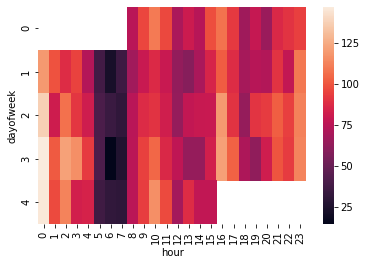

In [15]:
work_ride = work.pivot_table('num_orders', 'dayofweek', 'hour')
ax_2 = sns.heatmap(work_ride)

Схожее распеределение с общим графиком. Посмотрим на выходные.

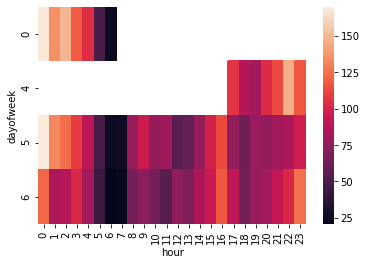

In [16]:
weekend_ride = weekend.pivot_table('num_orders', 'dayofweek', 'hour')
ax_3 = sns.heatmap(weekend_ride)

Выходные дают те же данные, плюс увидели стабильное увеличение заказов в 16 часов.

Вывод: 
- На протяжении всей выборки есть растущий тренд количества заказов.
- Сезонность не прослеживается.
- Очевидный рост заказов около полуночи в в районе 16 часов.
- Абсолютное падение количества заказов от 5 до 7 утра.
- Зависимости в распределении количества заказов между будними и выходными днями не прослеживается.

# 3. Обучение

Теперь приступим к обучению моделей для прогнозирования количества заказов.

Нам необходим горизонт прогнозирования в один час, ресемплинг мы уже сделали в самом начале.

В процессе анализа мы уже добавили два признака - день недели и час. Теперь необходимо добавить еще скользящее среднее.

In [17]:
df['rolling_mean'] = df['num_orders'].shift().rolling(5).mean()
df.head(10)

,num_orders,dayofweek,hour,rolling_mean
datetime,,,,
2018-03-01 00:00:00,124,3,0,NaN
2018-03-01 01:00:00,85,3,1,NaN
2018-03-01 02:00:00,71,3,2,NaN
2018-03-01 03:00:00,66,3,3,NaN
2018-03-01 04:00:00,43,3,4,NaN
2018-03-01 05:00:00,6,3,5,77.8
2018-03-01 06:00:00,12,3,6,54.2
2018-03-01 07:00:00,15,3,7,39.6
2018-03-01 08:00:00,34,3,8,28.4


Разобьем датасет на обучающую и тестовую выборки.

In [18]:
train, test = train_test_split(df, shuffle=False, test_size=0.2)

Удалим из выборок пропущенные значения, которые появились при подсчете скользящего среднего, также приведем среднее к целочисленным значениям.

In [19]:
train = train.dropna()
train = train.astype('int')
train

,num_orders,dayofweek,hour,rolling_mean
datetime,,,,
2018-03-01 05:00:00,6,3,5,77
2018-03-01 06:00:00,12,3,6,54
2018-03-01 07:00:00,15,3,7,39
2018-03-01 08:00:00,34,3,8,28
2018-03-01 09:00:00,69,3,9,22
...,...,...,...,...
2018-07-25 23:00:00,138,2,23,102
2018-07-26 00:00:00,149,3,0,116
2018-07-26 01:00:00,73,3,1,118


In [20]:
test = test.dropna()
test = test.astype('int')
test

,num_orders,dayofweek,hour,rolling_mean
datetime,,,,
2018-07-26 04:00:00,131,3,4,139
2018-07-26 05:00:00,83,3,5,138
2018-07-26 06:00:00,21,3,6,125
2018-07-26 07:00:00,39,3,7,114
2018-07-26 08:00:00,80,3,8,83
...,...,...,...,...
2018-08-31 19:00:00,136,4,19,174
2018-08-31 20:00:00,154,4,20,174
2018-08-31 21:00:00,159,4,21,182


Выделим признаки и целевой признак на выборках.

In [21]:
features_train = train.drop(columns=['num_orders'])
features_test = test.drop(columns=['num_orders'])
target_train = train.num_orders
target_test = test.num_orders

Введем формулу rmse, как главной метрики для нас.

In [22]:
def rmse(target, predictions):
    return (((target-predictions)**2).mean())**0.5 

Начнем с модели линейной регрессии.

In [23]:
model = LinearRegression()
model.fit(features_train, target_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Попробуем градиентный бустинг, начнем с catboost и подбор параметров при помощи gridsearch.

In [24]:
cat_features = ['dayofweek', 'hour', 'rolling_mean']

model_cat = CatBoostRegressor()
 
params = {'iterations': range (1, 130, 25),
          'depth': range (1, 10, 2),
          }
 
grid = GridSearchCV(model_cat, params, cv=5)

grid.fit(features_train, target_train)

grid.best_params_

0:	learn: 35.7025510	total: 47ms	remaining: 0us
0:	learn: 36.0410012	total: 712us	remaining: 0us
0:	learn: 35.6744563	total: 728us	remaining: 0us
0:	learn: 36.2926933	total: 751us	remaining: 0us
0:	learn: 33.4101974	total: 728us	remaining: 0us
0:	learn: 35.7025510	total: 704us	remaining: 17.6ms
1:	learn: 35.5910473	total: 1.44ms	remaining: 17.3ms
2:	learn: 35.4649611	total: 2.08ms	remaining: 15.9ms
3:	learn: 35.3652693	total: 2.6ms	remaining: 14.3ms
4:	learn: 35.2514819	total: 4ms	remaining: 16.8ms
5:	learn: 35.1482363	total: 4.66ms	remaining: 15.5ms
6:	learn: 35.0575599	total: 5.37ms	remaining: 14.6ms
7:	learn: 34.9804507	total: 6.01ms	remaining: 13.5ms
8:	learn: 34.8815095	total: 6.6ms	remaining: 12.5ms
9:	learn: 34.7893193	total: 7.25ms	remaining: 11.6ms
10:	learn: 34.7022257	total: 7.86ms	remaining: 10.7ms
11:	learn: 34.6133618	total: 8.4ms	remaining: 9.81ms
12:	learn: 34.5332309	total: 8.94ms	remaining: 8.94ms
13:	learn: 34.4649636	total: 9.53ms	remaining: 8.17ms
14:	learn: 34.390

{'depth': 9, 'iterations': 126}

Лучшая комбинация 9-126. Обучим модель.

In [25]:
model_cat = CatBoostRegressor(iterations = 126, depth = 9)

model_cat.fit(features_train, target_train, cat_features=cat_features, verbose=1)

0:	learn: 35.3182448	total: 5.23ms	remaining: 653ms
1:	learn: 34.9270144	total: 8.02ms	remaining: 497ms
2:	learn: 34.5735030	total: 9.88ms	remaining: 405ms
3:	learn: 34.2360973	total: 11.5ms	remaining: 351ms
4:	learn: 33.8961657	total: 14.2ms	remaining: 344ms
5:	learn: 33.5698411	total: 17ms	remaining: 340ms
6:	learn: 33.2590362	total: 18.6ms	remaining: 316ms
7:	learn: 32.9977503	total: 107ms	remaining: 1.57s
8:	learn: 32.7643480	total: 108ms	remaining: 1.41s
9:	learn: 32.5545749	total: 109ms	remaining: 1.27s
10:	learn: 32.3046620	total: 111ms	remaining: 1.16s
11:	learn: 32.0707028	total: 114ms	remaining: 1.08s
12:	learn: 31.8461104	total: 117ms	remaining: 1.02s
13:	learn: 31.6239397	total: 206ms	remaining: 1.65s
14:	learn: 31.4081783	total: 209ms	remaining: 1.55s
15:	learn: 31.2201927	total: 211ms	remaining: 1.45s
16:	learn: 31.0569525	total: 212ms	remaining: 1.36s
17:	learn: 30.8855246	total: 213ms	remaining: 1.28s
18:	learn: 30.7191116	total: 221ms	remaining: 1.24s
19:	learn: 30.571

Теперь перейдем к LGBMRegressor.

In [26]:
gbm = lgb.LGBMRegressor()

params_lgb = {'n_estimators': range (1, 100, 10),
              'learning_rate': [0.1, 0.2]}
 
grid_lgb = GridSearchCV(gbm, params_lgb, cv=5)

grid_lgb.fit(features_train, target_train)

grid_lgb.best_params_

{'learning_rate': 0.1, 'n_estimators': 51}

Лучшие параметры 0.1 - 51. Обучим модель.

In [27]:
gbm = lgb.LGBMRegressor(n_estimators = 51, learnig_rate = 0.1)

gbm.fit(features_train, target_train, eval_set=[(features_test, target_test)])

[1]	valid_0's l2: 5151.96
[2]	valid_0's l2: 4825.42
[3]	valid_0's l2: 4532.19
[4]	valid_0's l2: 4297.39
[5]	valid_0's l2: 4079.21
[6]	valid_0's l2: 3891.08
[7]	valid_0's l2: 3723.41
[8]	valid_0's l2: 3579.02
[9]	valid_0's l2: 3451.23
[10]	valid_0's l2: 3344.89
[11]	valid_0's l2: 3257.86
[12]	valid_0's l2: 3194.25
[13]	valid_0's l2: 3109.39
[14]	valid_0's l2: 3044.64
[15]	valid_0's l2: 2984.29
[16]	valid_0's l2: 2906.44
[17]	valid_0's l2: 2846.95
[18]	valid_0's l2: 2786.85
[19]	valid_0's l2: 2740.07
[20]	valid_0's l2: 2688.18
[21]	valid_0's l2: 2650.66
[22]	valid_0's l2: 2616.15
[23]	valid_0's l2: 2583.91
[24]	valid_0's l2: 2540.12
[25]	valid_0's l2: 2521.47
[26]	valid_0's l2: 2494.01
[27]	valid_0's l2: 2470.34
[28]	valid_0's l2: 2457.04
[29]	valid_0's l2: 2439.66
[30]	valid_0's l2: 2415.32
[31]	valid_0's l2: 2404.74
[32]	valid_0's l2: 2390.81
[33]	valid_0's l2: 2370.25
[34]	valid_0's l2: 2358.38
[35]	valid_0's l2: 2352.25
[36]	valid_0's l2: 2343.93
[37]	valid_0's l2: 2340.46
[38]	valid

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learnig_rate=0.1, learning_rate=0.1,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=51, n_jobs=-1, num_leaves=31,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

Модели обучены, отправимся на тестирование.

# 4. Тестирование

Приступим к тестированию - посчитаем RMSE каждой модели на тестовой выборке.

Сначала предсказания

In [28]:
predictions = model.predict(features_test)
predictions_lgb = gbm.predict(features_test)
predictions_cat = model_cat.predict(features_test)

In [29]:
print("RMSE на тестовой выборке на модели линейной регрессии равно:", rmse(target_test, predictions))
print("RMSE на тестовой выборке на модели бустинга CatBoost равно:", rmse(target_test, predictions_cat))
print("RMSE на тестовой выборке на модели бустинга LGBM равно:", rmse(target_test, predictions_lgb))

RMSE на тестовой выборке на модели линейной регрессии равно: 58.45427352638381
RMSE на тестовой выборке на модели бустинга CatBoost равно: 57.079501535445814
RMSE на тестовой выборке на модели бустинга LGBM равно: 48.053715509645954


Лучшая модель - LGBMRegressor. Попробуем сравнить предсказания с фактическими показателями. Для этого построим обычный линейный график на дистанции в пять дней.

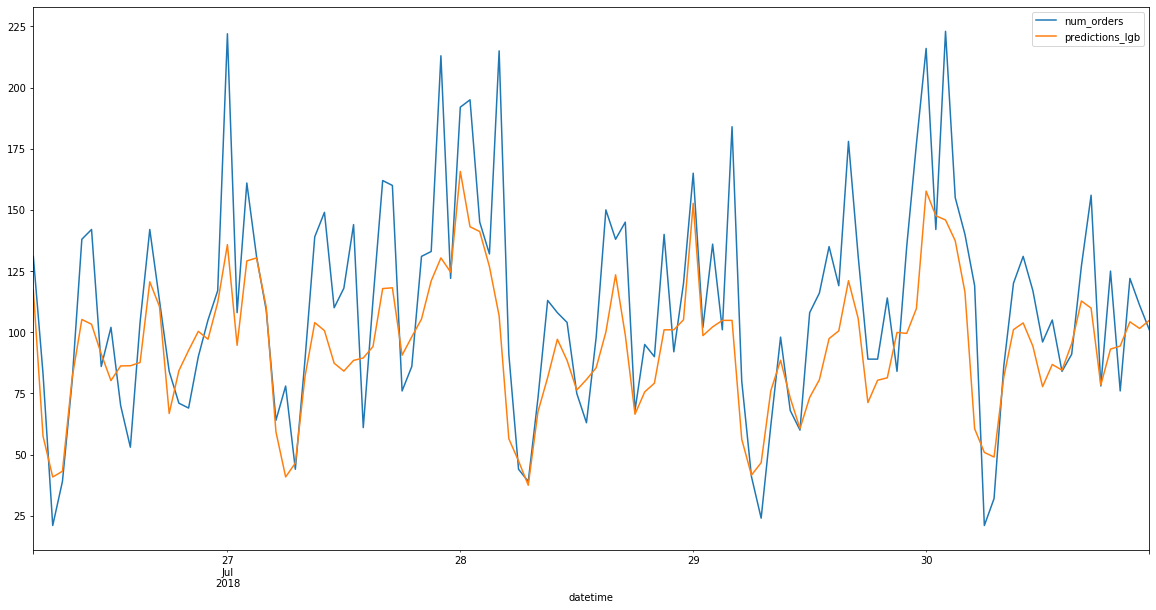

In [30]:
test['predictions_lgb'] = predictions_lgb
test_sample = test['2018-07-26':'2018-07-30']
test_sample['num_orders'].plot(legend=True, figsize=(20,10))
test_sample['predictions_lgb'].plot(legend=True, figsize=(20,10))
plt.show()

Ошибка предсказания существенна. Попробуем отследить. Построим столбец ошибки предсказания и проанализируем его.

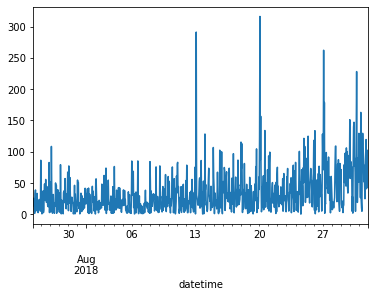

In [31]:
test['mistake'] = abs(test['num_orders'] - test['predictions_lgb'])
test['mistake'].plot()

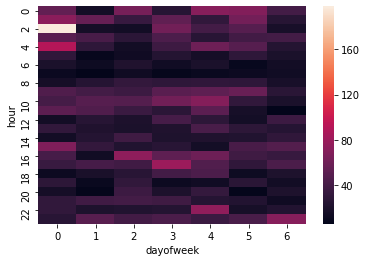

In [32]:
mistake_hour = test.pivot_table('mistake', 'hour', 'dayofweek')
ax_3 = sns.heatmap(mistake_hour)

Наиболее ярко выделяется только количество ошибок в 2 часа ночи в понедельник. Попробуем построить график автокорреляций.

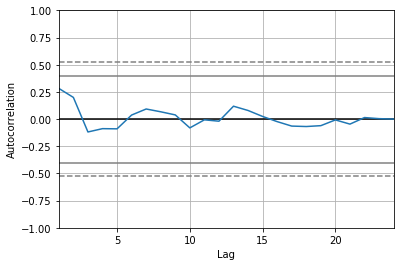

In [33]:
pd.plotting.autocorrelation_plot(mistake_hour)

Согласно этому графику, чтобы построить максимально точную модель, нам необходимо добавить lag. Начнем с единицы и заново разделим массив, обучим модель, посчитаем RMSE и посмотрим на график с ошибками предсказания.

[1]	valid_0's l2: 5150.32
[2]	valid_0's l2: 4817.13
[3]	valid_0's l2: 4554.98
[4]	valid_0's l2: 4312.74
[5]	valid_0's l2: 4084.61
[6]	valid_0's l2: 3883.69
[7]	valid_0's l2: 3732.34
[8]	valid_0's l2: 3589.87
[9]	valid_0's l2: 3461.35
[10]	valid_0's l2: 3342.02
[11]	valid_0's l2: 3255.21
[12]	valid_0's l2: 3177.48
[13]	valid_0's l2: 3101.85
[14]	valid_0's l2: 3009.7
[15]	valid_0's l2: 2944.8
[16]	valid_0's l2: 2887.03
[17]	valid_0's l2: 2811.21
[18]	valid_0's l2: 2770.14
[19]	valid_0's l2: 2728.29
[20]	valid_0's l2: 2702.78
[21]	valid_0's l2: 2676.61
[22]	valid_0's l2: 2650.61
[23]	valid_0's l2: 2611.08
[24]	valid_0's l2: 2596.02
[25]	valid_0's l2: 2578.65
[26]	valid_0's l2: 2556.31
[27]	valid_0's l2: 2535.28
[28]	valid_0's l2: 2520.14
[29]	valid_0's l2: 2507.29
[30]	valid_0's l2: 2483.21
[31]	valid_0's l2: 2466.84
[32]	valid_0's l2: 2447.85
[33]	valid_0's l2: 2426.83
[34]	valid_0's l2: 2416.49
[35]	valid_0's l2: 2407.28
[36]	valid_0's l2: 2390.06
[37]	valid_0's l2: 2364.93
[38]	valid_0

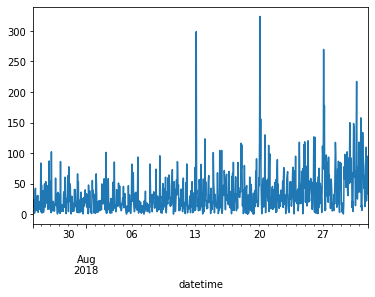

In [34]:
#Добавляем Lag_1
df['lag_1'] = df['num_orders'].shift(1)

#Делим массив
train, test = train_test_split(df, shuffle=False, test_size=0.2)

#Убираем пропуски и делаем значения целочисленными
train = train.dropna()
train = train.astype('int')
test = test.dropna()
test = test.astype('int')

#Получаем тестовую и тренировочную выборки
features_train = train.drop(columns=['num_orders'])
features_test = test.drop(columns=['num_orders'])
target_train = train.num_orders
target_test = test.num_orders

#Гридсерч уже определял наиболее выгодные параметры, поэтому просто обучаем заново.
gbm = lgb.LGBMRegressor(n_estimators = 51, learnig_rate = 0.1)
gbm.fit(features_train, target_train, eval_set=[(features_test, target_test)])

#Получаем предсказания
predictions_lgb = gbm.predict(features_test)

#Считаем RMSE
print("RMSE на тестовой выборке на модели бустинга LGBM равно:", rmse(target_test, predictions_lgb))

#Создаем столбец ошибок и смотрим на график
test['predictions_lgb'] = predictions_lgb
test['mistake'] = abs(test['num_orders'] - test['predictions_lgb'])
test['mistake'].plot()

Добавление lag_1 незначително повлияло на ошибки предсказания. Добавим lag_2.

[1]	valid_0's l2: 5136.06
[2]	valid_0's l2: 4848.84
[3]	valid_0's l2: 4550.55
[4]	valid_0's l2: 4298.3
[5]	valid_0's l2: 4077.23
[6]	valid_0's l2: 3899.54
[7]	valid_0's l2: 3702.21
[8]	valid_0's l2: 3565.16
[9]	valid_0's l2: 3424.74
[10]	valid_0's l2: 3321.48
[11]	valid_0's l2: 3214.81
[12]	valid_0's l2: 3132.8
[13]	valid_0's l2: 3053.5
[14]	valid_0's l2: 2991.35
[15]	valid_0's l2: 2928.9
[16]	valid_0's l2: 2879.31
[17]	valid_0's l2: 2789.33
[18]	valid_0's l2: 2752.29
[19]	valid_0's l2: 2712.87
[20]	valid_0's l2: 2669.89
[21]	valid_0's l2: 2635.83
[22]	valid_0's l2: 2608.68
[23]	valid_0's l2: 2570.02
[24]	valid_0's l2: 2556.44
[25]	valid_0's l2: 2523.72
[26]	valid_0's l2: 2497.04
[27]	valid_0's l2: 2459.95
[28]	valid_0's l2: 2448.72
[29]	valid_0's l2: 2425.3
[30]	valid_0's l2: 2400.84
[31]	valid_0's l2: 2384.02
[32]	valid_0's l2: 2374.14
[33]	valid_0's l2: 2382.11
[34]	valid_0's l2: 2393.13
[35]	valid_0's l2: 2373.97
[36]	valid_0's l2: 2366.49
[37]	valid_0's l2: 2353.81
[38]	valid_0's 

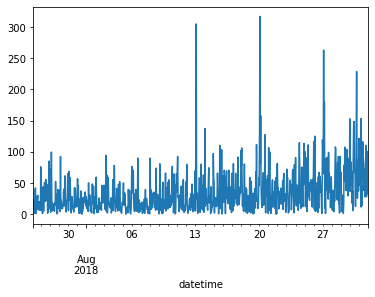

In [35]:
#Добавляем Lag_2
df['lag_2'] = df['num_orders'].shift(2)

#Делим массив
train, test = train_test_split(df, shuffle=False, test_size=0.2)

#Убираем пропуски и делаем значения целочисленными
train = train.dropna()
train = train.astype('int')
test = test.dropna()
test = test.astype('int')

#Получаем тестовую и тренировочную выборки
features_train = train.drop(columns=['num_orders'])
features_test = test.drop(columns=['num_orders'])
target_train = train.num_orders
target_test = test.num_orders

#Гридсерч уже определял наиболее выгодные параметры, поэтому просто обучаем заново.
gbm = lgb.LGBMRegressor(n_estimators = 51, learnig_rate = 0.1)
gbm.fit(features_train, target_train, eval_set=[(features_test, target_test)])

#Получаем предсказания
predictions_lgb = gbm.predict(features_test)

#Считаем RMSE
print("RMSE на тестовой выборке на модели бустинга LGBM равно:", rmse(target_test, predictions_lgb))

#Создаем столбец ошибок и смотрим на график
test['predictions_lgb'] = predictions_lgb
test['mistake'] = abs(test['num_orders'] - test['predictions_lgb'])
test['mistake'].plot()

Добавляем lag_3.

[1]	valid_0's l2: 5143
[2]	valid_0's l2: 4855.7
[3]	valid_0's l2: 4553.27
[4]	valid_0's l2: 4294.08
[5]	valid_0's l2: 4054.15
[6]	valid_0's l2: 3874.48
[7]	valid_0's l2: 3692.96
[8]	valid_0's l2: 3569.39
[9]	valid_0's l2: 3453.57
[10]	valid_0's l2: 3316.3
[11]	valid_0's l2: 3217.63
[12]	valid_0's l2: 3107.31
[13]	valid_0's l2: 3048.96
[14]	valid_0's l2: 2970.59
[15]	valid_0's l2: 2914.38
[16]	valid_0's l2: 2859.84
[17]	valid_0's l2: 2784.42
[18]	valid_0's l2: 2721.84
[19]	valid_0's l2: 2700.33
[20]	valid_0's l2: 2659.38
[21]	valid_0's l2: 2633.59
[22]	valid_0's l2: 2609.54
[23]	valid_0's l2: 2602.37
[24]	valid_0's l2: 2586.8
[25]	valid_0's l2: 2560.1
[26]	valid_0's l2: 2533.77
[27]	valid_0's l2: 2531.94
[28]	valid_0's l2: 2510.39
[29]	valid_0's l2: 2480.96
[30]	valid_0's l2: 2458.8
[31]	valid_0's l2: 2448.27
[32]	valid_0's l2: 2433.25
[33]	valid_0's l2: 2424.59
[34]	valid_0's l2: 2418.5
[35]	valid_0's l2: 2422.34
[36]	valid_0's l2: 2403.71
[37]	valid_0's l2: 2389.56
[38]	valid_0's l2: 

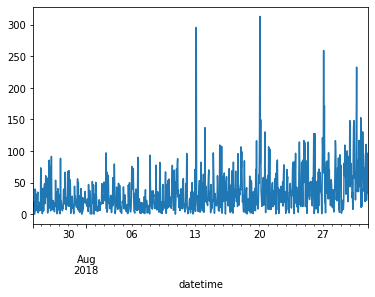

In [36]:
#Добавляем Lag_3
df['lag_3'] = df['num_orders'].shift(3)

#Делим массив
train, test = train_test_split(df, shuffle=False, test_size=0.2)

#Убираем пропуски и делаем значения целочисленными
train = train.dropna()
train = train.astype('int')
test = test.dropna()
test = test.astype('int')

#Получаем тестовую и тренировочную выборки
features_train = train.drop(columns=['num_orders'])
features_test = test.drop(columns=['num_orders'])
target_train = train.num_orders
target_test = test.num_orders

#Гридсерч уже определял наиболее выгодные параметры, поэтому просто обучаем заново.
gbm = lgb.LGBMRegressor(n_estimators = 51, learnig_rate = 0.1)
gbm.fit(features_train, target_train, eval_set=[(features_test, target_test)])

#Получаем предсказания
predictions_lgb = gbm.predict(features_test)

#Считаем RMSE
print("RMSE на тестовой выборке на модели бустинга LGBM равно:", rmse(target_test, predictions_lgb))

#Создаем столбец ошибок и смотрим на график
test['predictions_lgb'] = predictions_lgb
test['mistake'] = abs(test['num_orders'] - test['predictions_lgb'])
test['mistake'].plot()

In [37]:
test

,num_orders,dayofweek,hour,rolling_mean,lag_1,lag_2,lag_3,predictions_lgb,mistake
datetime,,,,,,,,,
2018-07-26 04:00:00,131,3,4,139,141,197,73,115.755515,15.244485
2018-07-26 05:00:00,83,3,5,138,131,141,197,63.895501,19.104499
2018-07-26 06:00:00,21,3,6,125,83,131,141,38.272358,17.272358
2018-07-26 07:00:00,39,3,7,114,21,83,131,39.307547,0.307547
2018-07-26 08:00:00,80,3,8,83,39,21,83,79.955639,0.044361
...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,174,207,217,197,114.128416,21.871584
2018-08-31 20:00:00,154,4,20,174,136,207,217,113.585980,40.414020
2018-08-31 21:00:00,159,4,21,182,154,136,207,125.790086,33.209914


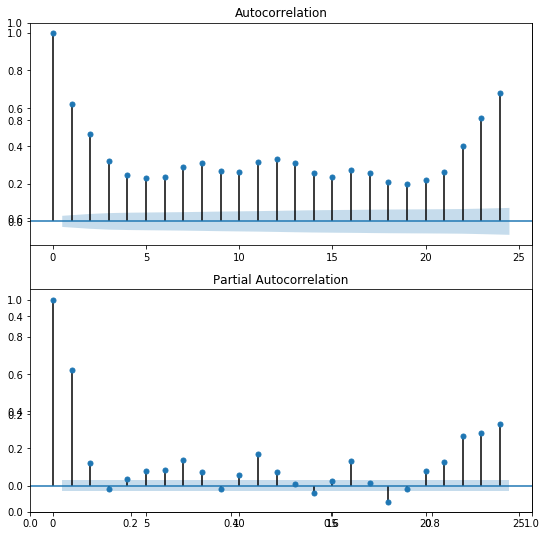

In [38]:
fig, ax = plt.subplots(figsize=(9, 9))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['num_orders'], lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['num_orders'], lags=24, ax=ax2)

Вывод:
- лучшей моделью для предсказания количества заказов такси является LGBMRegressor - RMSE равен 47.2.
- основываясь на графике сравнения актуальных данных и предсказания LGBMRegressor можно заключить, что модель предсказывает количество заказов  недостаточно хорошо, и пиковый спрос отслежтвается не так, как требуется.

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48